# Setup

In [ ]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt;plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torch.utils.data import DataLoader
import copy 

cpu


# Data

In [ ]:
languages = []
data = []
X = []
Y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        Y.append(lang)
        data.append((name, lang))
n_languages = len(languages)

def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

all_letters = string.ascii_letters + " .,;'";n_letters = len(all_letters)

def infer(net, name):
    name_ohe = name_rep(name)
    hidden = net.init_hidden()
    
    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)
    
    return output


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print(len(X_train),len(X_test),len(Y_train),len(Y_test))
trainset = []
for x,y in zip(X_train,Y_train):
    trainset.append([x,y])

16040 4010 16040 4010


In [ ]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
      #for input, arg1,arg2,arg3 -> #charcters, #batches, #encoding size of each character (basically the size of a single character's OHE)
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
      #Here arg1, arg2, arg3 -> #layers, #batches, #hidden_size of neurons
        return torch.zeros(1, 1, self.hidden_size,device=device)
        
##########################################################################################################################

n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
net = net.to(device)
best_model = copy.deepcopy(net.state_dict())

In [ ]:
def train_setup(net, lr = 0.01, batch_size = 64, momentum = 0.9, k = 1, display_freq=1):

    criterion = nn.NLLLoss();min_loss = 1000
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    fig, ax = plt.subplots(2, 2)

    for btch,data in enumerate(trainloader):

        # Train Mini-Batch Pass
        count = 0
        net.train();opt.zero_grad();train_loss,train_acc =0.0,0.0
        for i_btch in range (len(data[0])):
            #Forward
            name, lang = name_rep(data[0][i_btch]), lang_rep(data[1][i_btch])
            name_ohe, lang_ohe = name.to(device), lang.to(device)

            hidden = net.init_hidden();hidden.to(device)
            for i in range(name_ohe.size()[0]):
                output, hidden = net(name_ohe[i], hidden)
            loss = criterion(output, lang_ohe)
            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(net.state_dict())

            loss.backward(retain_graph=True)
            train_loss += loss.item()
            val, indices = output.topk(k)
            count+=1
            if lang_ohe in indices:
                train_acc +=1

        opt.step()
        train_loss /= batch_size;train_acc /= batch_size
        del name, lang, name_ohe, lang_ohe, hidden, output, val, indices    

        #Test Full-Batch Pass
        with torch.no_grad():
            net.eval()
            test_loss,test_acc = 0,0
            for name,lang in zip(X_test,Y_test):
                output = infer(net, name)
                test_loss += criterion(output, lang_rep(lang)).item()
                val, indices = output.topk(k)
                if lang_rep(lang) in indices:
                    test_acc +=1

            test_loss /= len(Y_test)
            test_acc /= len(Y_test)
        train_losses.append(train_loss);train_accuracies.append(train_acc)
        test_losses.append(test_loss);test_accuracies.append(test_acc)

        # Plotting
        if not (btch%display_freq):
            clear_output(wait=True)
            fig, ax = plt.subplots(2,figsize=(5,8));ax = ax.flatten()
            print("Batch: ",btch,"Train Loss: ",round(train_loss,5),"Train Acc: ",round(train_acc,3) ,"Test Loss: ",round(test_loss,5), "Test Acc: ",round(test_acc,3))
            ax[0].plot(train_losses,'r',label = "Train");ax[0].plot(test_losses,'g',label = "Test")
            ax[1].plot(train_accuracies,'r',label = "Train");ax[1].plot(test_accuracies,'g',label = "Test")
            ax[0].set_xlabel('Iteration');ax[0].set_ylabel('Loss');ax[1].set_xlabel('Iteration');ax[1].set_ylabel('Top-k acc')
            ax[0].legend();ax[1].legend();plt.show();print('\n\n')

        del name, lang, output, val, indices, train_loss, train_acc, test_loss, test_acc

########################################################################################################################

In [ ]:
# checkpoint = {'model': GRU_net(),'state_dict': best_model.state_dict(),'optimizer' : opt.state_dict()}
checkpoint = {'state_dict': best_model}
torch.save(checkpoint, 'checkpoint.pth')
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    #net = checkpoint['model']
    net.load_state_dict(checkpoint['state_dict'])
    # for parameter in model.parameters():
    #     parameter.requires_grad = False
    # net.eval()
    return net


In [ ]:
net = load_checkpoint('checkpoint.pth')
print(net)

GRU_net(
  (gru_cell): GRU(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=2)
)


Batch:  60 Train Loss:  1.33295 Train Acc:  0.605 Test Loss:  1.16968 Test Acc:  0.649


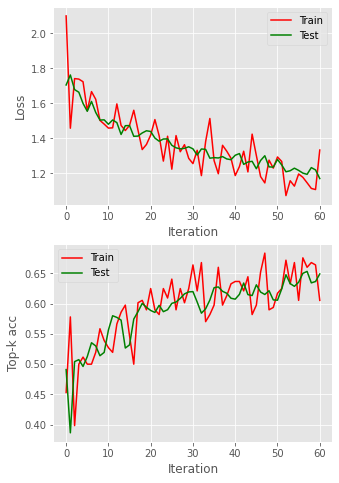

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = [],[],[],[]
train_setup(net, lr=0.0015, batch_size = 256,momentum = 0.9, k = 1, display_freq=5)

In [ ]:
def compare_models(dict1, dict2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(dict1.items(), dict2.items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')

In [ ]:
compare_models(best_model,net.state_dict())

Models match perfectly! :)
